In [ ]:
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, fbeta_score, classification_report, matthews_corrcoef
from sklearn.metrics import make_scorer 
import matplotlib.pyplot as plt
import gensim.downloader as api

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
dir_name = "/content/gdrive/MyDrive/Thesis/"

Mounted at /content/gdrive


In [ ]:
def get_raw_data(dir_name, file_name):
    #  load data
    data = pd.read_csv('{}{}.csv'.format(dir_name,file_name), encoding = 'latin-1', usecols=['Message_body', 'Label'])
    data = data.rename(columns={'Label': 'label', 'Message_body': 'text'})
    le = LabelEncoder()
    data['label'] = le.fit_transform( data['label'])
    return data

In [ ]:
raw_train_data = get_raw_data(dir_name + 'datasets/email_spam/', 'train')

In [ ]:
raw_train_data

,text,label
0,Rofl. Its true to its name,0
1,The guy did some bitching but I acted like i'd...,0
2,"Pity, * was in mood for that. So...any other s...",0
3,Will ü b going to esplanade fr home?,0
4,This is the 2nd time we have tried 2 contact u...,1
...,...,...
952,hows my favourite person today? r u workin har...,0
953,How much you got for cleaning,0
954,Sorry da. I gone mad so many pending works wha...,0
955,Wat time ü finish?,0


In [ ]:
raw_train_data['text'].is_unique

False

In [ ]:
raw_train_data.drop_duplicates(subset=['text'], inplace=True)

In [ ]:
raw_train_data['text'].is_unique

True

In [ ]:
raw_train_data

,text,label
0,Rofl. Its true to its name,0
1,The guy did some bitching but I acted like i'd...,0
2,"Pity, * was in mood for that. So...any other s...",0
3,Will ü b going to esplanade fr home?,0
4,This is the 2nd time we have tried 2 contact u...,1
...,...,...
952,hows my favourite person today? r u workin har...,0
953,How much you got for cleaning,0
954,Sorry da. I gone mad so many pending works wha...,0
955,Wat time ü finish?,0


In [ ]:
def get_dataset_statistics(data):
    dataset_statistics = {'Number of emails': [data['label'].value_counts()[0], data['label'].value_counts()[1]]}
    df = pd.DataFrame(dataset_statistics, index=['Non-Spam', 'Spam'])
    df.plot(kind='pie', y='Number of emails', figsize=(6, 6), fontsize=14,
            autopct=lambda v: '{:.0f} ({:.1f}%)'.format(v / 100 * data['label'].count(), v))

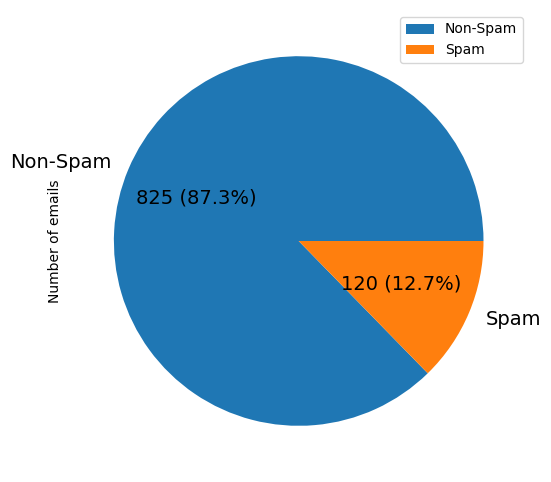

In [ ]:
# Raw data statistics
get_dataset_statistics(raw_train_data)

In [ ]:
raw_test_data = get_raw_data(dir_name + 'datasets/email_spam/', 'test')

In [ ]:
raw_test_data

,text,label
0,"UpgrdCentre Orange customer, you may now claim...",1
1,"Loan for any purpose £500 - £75,000. Homeowner...",1
2,Congrats! Nokia 3650 video camera phone is you...,1
3,URGENT! Your Mobile number has been awarded wi...,1
4,Someone has contacted our dating service and e...,1
...,...,...
120,7 wonders in My WORLD 7th You 6th Ur style 5th...,0
121,Try to do something dear. You read something f...,0
122,Sun ah... Thk mayb can if dun have anythin on....,0
123,"SYMPTOMS when U are in love: ""1.U like listeni...",0


In [ ]:
raw_test_data['label'].value_counts()

1    76
0    49
Name: label, dtype: int64

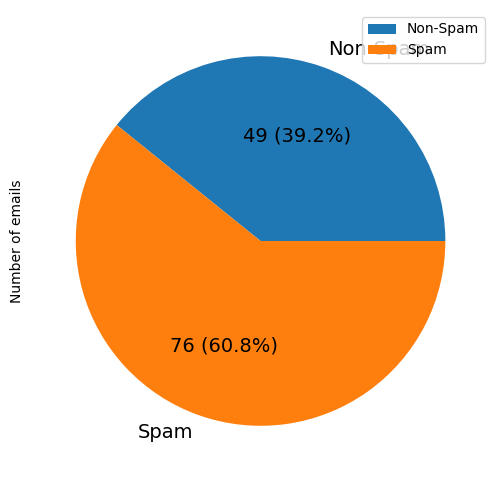

In [ ]:
get_dataset_statistics(raw_test_data)

# Text Preprocessing 

In [ ]:
import requests
stopwords_list = requests.get("https://github.com/stopwords-iso/stopwords-en/blob/master/stopwords-en.txt").content
stopwords = set(stopwords_list.decode().splitlines())

In [ ]:
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
sklearn_stopwords = ENGLISH_STOP_WORDS

stop_words = set(stopwords.words('english'))
stop_words.update(sklearn_stopwords)

def message_preprocessing(raw_message):
  message_words = raw_message.translate(str.maketrans('', '', string.punctuation))
  msg_tokens = word_tokenize(message_words.lower())
  filtered_message = [token for token in msg_tokens if not token in stop_words]
  return " ".join(filtered_message)

In [ ]:
train_data = raw_train_data[['text', 'label']].copy()

train_data['text'] = raw_train_data['text'].apply(message_preprocessing)

train_data.drop_duplicates(inplace=True)

train_data

,text,label
0,rofl true,0
1,guy bitching acted like id interested buying w...,0
2,pity mood soany suggestions,0
3,ü b going esplanade fr home,0
4,2nd time tried 2 contact u u £750 pound prize ...,1
...,...,...
952,hows favourite person today r u workin hard sl...,0
953,got cleaning,0
954,sorry da gone mad pending works,0
955,wat time ü finish,0


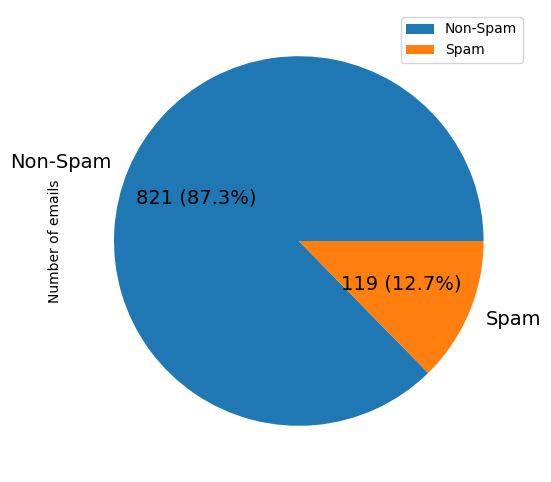

In [ ]:
get_dataset_statistics(train_data)

In [ ]:
test_data = raw_test_data[['text', 'label']].copy()

test_data['text'] = raw_test_data['text'].apply(message_preprocessing)

test_data.drop_duplicates(inplace=True)

test_data

,text,label
0,upgrdcentre orange customer claim free camera ...,1
1,loan purpose £500 £75000 homeowners tenants we...,1
2,congrats nokia 3650 video camera phone 0906638...,1
3,urgent mobile number awarded £2000 prize guara...,1
4,contacted dating service entered phone fancy l...,1
...,...,...
120,7 wonders world 7th 6th ur style 5th ur smile ...,0
121,try dear read exams,0
122,sun ah thk mayb dun anythin thk book e lesson ...,0
123,symptoms u love 1u like listening songs 2u sto...,0


In [ ]:
word2vec_model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
def get_text_vec(sent):
  vector = np.mean(np.array([word2vec_model[token] for token in word_tokenize(sent) if token in word2vec_model.key_to_index]), axis=0)
  if np.all(np.isnan(vector)) :
    return np.zeros(300)
  return vector

In [ ]:
X_test = np.stack(np.array([get_text_vec(sms_text) for sms_text in test_data['text'].values]))

In [ ]:
X_test.shape

(124, 300)

In [ ]:
y_test = test_data['label'].values

In [ ]:
y_test.shape

(124,)

# Model selection, training and evaluation

In [ ]:
def f_beta_score(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2, average='binary')

f2_score = make_scorer(f_beta_score, greater_is_better=True)

In [ ]:
from datetime import datetime

def save_cross_validation(results, file_name):
  results_to_save = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision', 'F1 Score', 'F2 Score', 'MCC'])
  for i in range(0, 10):
    results_to_save.loc[i] = [
      results['split{}_test_Accuracy'.format(i)][0],
      results['split{}_test_Recall'.format(i)][0],
      results['split{}_test_Precision'.format(i)][0],
      results['split{}_test_F1'.format(i)][0],
      results['split{}_test_F2'.format(i)][0],
      results['split{}_test_MCC'.format(i)][0]
    ]
  results_to_save.to_csv('{}Results/{}_{}.csv'.format(dir_name+'experiments/Email Spam/', file_name, datetime.now().strftime("%m%d%H%M")))

In [ ]:
def train_model(classifier, param_grid, model_name, train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print=True, to_save=False, file_name=None):
    """
    train email classification model.
    """

    # apply grid search to find best model hyper parameters
    grid_search = GridSearchCV(classifier, param_grid, cv=10, scoring={'Accuracy': make_scorer(accuracy_score),
                                                                       'F1': make_scorer(f1_score),
                                                                       'F2': f2_score,
                                                                       'Recall': make_scorer(recall_score),
                                                                       'Precision': make_scorer(precision_score),
                                                                       'MCC' : make_scorer(matthews_corrcoef)
                                                                       }, refit='F1', n_jobs=-1)
    grid_search.fit(train_texts, train_labels)
    model = grid_search.best_estimator_

    if to_save:
      ConfusionMatrixDisplay(save_cross_validation(grid_search.cv_results_, file_name))
      plt.show()

    # train and test accuracy.
    test_accuracy = model.score(test_texts, test_labels)
    train_accuracy = model.score(train_texts, train_labels)

    # compute F1 score for model evaluation.
    y_pred = model.predict(test_texts)

    recall = recall_score(test_labels, y_pred)
    precision = precision_score(test_labels, y_pred)
    f1score = f1_score(test_labels, y_pred)
    f2score = fbeta_score(y_test, y_pred, beta=2, average='binary')
    mcc = matthews_corrcoef(y_test, y_pred)

    if to_print:
        print("train accuracy = " + str(train_accuracy))
        print("test accuracy = " + str(test_accuracy))
        print("Recall = {}".format(recall))
        print("Precision = {}".format(precision))
        print("F1 score = {}".format(f1score))
        print("F2 score = {}".format(f2score))
        print("MCC = {}".format(mcc))
        print(classification_report(test_labels, y_pred))


        # plot confusion matrix
        cm = confusion_matrix(test_labels, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

        disp.plot(cmap=plt.cm.Blues)
        plt.show()

        # print best model hyper parameters.
        print(grid_search.best_params_)

    evaluation_metrics.loc[model_name, 'Recall'] = recall
    evaluation_metrics.loc[model_name, 'Precision'] = precision
    evaluation_metrics.loc[model_name, 'F1 score'] = f1score
    evaluation_metrics.loc[model_name, 'F2 score'] = f2score
    evaluation_metrics.loc[model_name, 'MCC'] = mcc

    return f1score, f2score


def train(model_id, train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print=True, to_save=False, file_name=None):
    
    if model_id == 1:
        # Random forest Classification model.
        forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
        forest_param_grid = [{'n_estimators': [15,20,25,30], 'max_features': [5, 10, 15, 20], 'min_samples_split': [15, 20, 25], 'criterion': ['gini','entropy'], 'max_depth': [5,6,7,8]}]

        return train_model(forest_clf, forest_param_grid, 'RandomForest', train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print, to_save, file_name)

    if model_id == 2:
        # Support Vector Machine Model.
        svc_clf = SVC(random_state=42)
        svc_param_grid = [{'kernel': ['rbf'], 'degree': [2, 3 ,4, 5]}]

        return train_model(svc_clf, svc_param_grid, 'SVM', train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print, to_save, file_name)


# Text Augmentation

In [ ]:
from nltk.corpus import wordnet

def get_synonyms(word):
  synonyms = []
  for synonym in wordnet.synsets(word):
    for lemma in [l.name().lower() for l in synonym.lemmas()]:
      if len(lemma.split('_')) == 1 and lemma != word:
        synonyms.append(lemma)

  return list(set(synonyms))

In [ ]:
import itertools

def get_sentence_augmentations(sentence, similarity_threshold=.75):
  sentence_tokens = word_tokenize(sentence.lower())
  new_sentences = []
  words = []
  all_synonyms = []
  for word in sentence_tokens:
    if word in word2vec_model.key_to_index :
      synonyms = get_synonyms(word)
      if len(synonyms) > 0:
        good_synonyms = []
        for synonym in synonyms:
          if synonym in word2vec_model.key_to_index :
            if word2vec_model.similarity(word, synonym) >= similarity_threshold:
              good_synonyms.append(synonym)
        if len(good_synonyms) > 0:
          words.append(word)
          good_synonyms.append(word)
          all_synonyms.append(good_synonyms)
  for product in itertools.product(*all_synonyms):
    new_sentence = sentence
    for src, dest in zip(words, product):
        new_sentence = new_sentence.replace("%s" % src, dest)
    new_sentences.append(new_sentence.lower())
    # new_sentences.remove(sentence)
  return new_sentences

In [ ]:
def my_augmentation(prepro_dataset, lable, similarity_threshold=.75):
  messages = prepro_dataset.loc[prepro_dataset['label'] == 1]['text'].values
  new_messages = []
  for msg in messages:
    new_messages.extend(get_sentence_augmentations(msg, similarity_threshold))
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_messages), 'text':new_messages}), ignore_index = True)
  augmentations.drop_duplicates(inplace=True)
  return augmentations.sample(frac=1)

In [ ]:
# best .63
augmented_dataset = my_augmentation(train_data, 1, .63)

<ipython-input-26-40c4bd8a10bc>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_messages), 'text':new_messages}), ignore_index = True)


In [ ]:
augmented_dataset

,text,label
1050,ask 3mobile 0870 chatlines inclu free mins ind...,1
1913,dear voucher holder repast use following link ...,1
435,work ah den 6 plus lor u workin oso rite den o...,0
140,didnt complete gist oh,0
576,u today,0
...,...,...
590,urgent trying contact u todays draw shows £200...,1
182,friends help problems stupid suggestion lands ...,0
724,word checkmate chess comes persian phrase shah...,0
1499,£400 xmas reward waiting computer randomly pic...,1


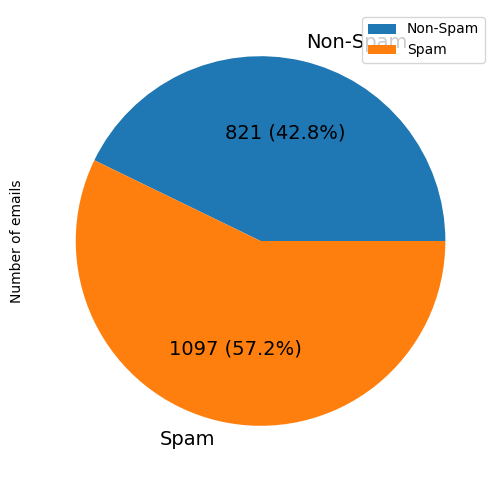

In [ ]:
get_dataset_statistics(augmented_dataset)

In [ ]:
aug_X_train = np.stack(np.array([get_text_vec(sms_text) for sms_text in augmented_dataset['text'].values]))

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
aug_X_train.shape

(1918, 300)

In [ ]:
aug_y_train = augmented_dataset['label'].values

In [ ]:
aug_y_train.shape

(1918,)

In [ ]:
evaluation_metrics_aug = pd.DataFrame(columns = ['Recall', 'Precision', 'F1 score', 'F2 score', 'MCC'])

## Random forest

train accuracy = 0.9927007299270073
test accuracy = 0.9032258064516129
Recall = 0.8533333333333334
Precision = 0.9846153846153847
F1 score = 0.9142857142857143
F2 score = 0.8767123287671234
MCC = 0.8153648283313745
              precision    recall  f1-score   support

           0       0.81      0.98      0.89        49
           1       0.98      0.85      0.91        75

    accuracy                           0.90       124
   macro avg       0.90      0.92      0.90       124
weighted avg       0.92      0.90      0.90       124



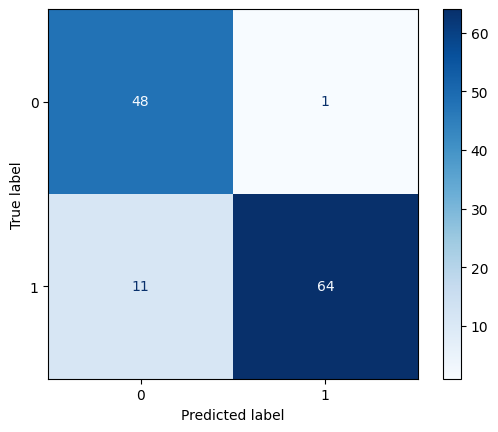

{'criterion': 'entropy', 'max_depth': 7, 'max_features': 15, 'min_samples_split': 20, 'n_estimators': 30}


(0.9142857142857143, 0.8767123287671234)

In [ ]:
train(1, aug_X_train, aug_y_train, X_test, y_test, evaluation_metrics_aug, to_save=True, file_name='TAMS_RF')

# SVM

train accuracy = 0.997393117831074
test accuracy = 0.9193548387096774
Recall = 0.88
Precision = 0.9850746268656716
F1 score = 0.9295774647887323
F2 score = 0.899182561307902
MCC = 0.8432301470982638
              precision    recall  f1-score   support

           0       0.84      0.98      0.91        49
           1       0.99      0.88      0.93        75

    accuracy                           0.92       124
   macro avg       0.91      0.93      0.92       124
weighted avg       0.93      0.92      0.92       124



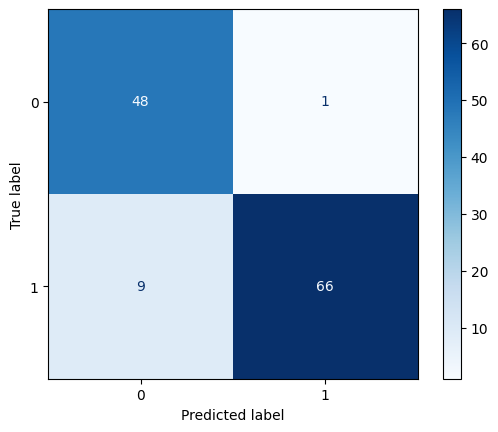

{'degree': 2, 'kernel': 'rbf'}


(0.9295774647887323, 0.899182561307902)

In [ ]:
train(2, aug_X_train, aug_y_train, X_test, y_test, evaluation_metrics_aug, to_save=True, file_name='TAMS_SVM')

#BiLSTM

In [ ]:
import random
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.regularizers import L1L2
from sklearn.model_selection import StratifiedKFold
seed = 221
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
text_words_lengths = [len(raw_train_data.loc[i]['text'].split()) for i in raw_train_data.index ]
total_length = np.sum(text_words_lengths)
text_words_mean = int(np.mean(text_words_lengths))

In [ ]:
def create_blstm_model(sent_length, words_mean, train_texts):

  text_vec = layers.TextVectorization( 
    max_tokens=sent_length,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=words_mean
  )

  text_vec.adapt(train_texts)

  embedding_layer = layers.Embedding(
    input_dim=sent_length,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=words_mean
  )

  input_layer = layers.Input(shape=(1,), dtype=tf.string) 

  vec_layer = text_vec(input_layer)
  embedding_layer_model = embedding_layer(vec_layer) 

  bi_lstm = layers.Bidirectional(layers.LSTM(64, activation='relu', return_sequences=True, kernel_regularizer = L1L2(l1=0.01, l2=0.0)))(embedding_layer_model) 

  flatten = layers.Flatten()(bi_lstm) 
  dropout = layers.Dropout(.1)(flatten) 

  x = layers.Dense(32, activation='relu')(dropout) 

  output_layer = layers.Dense(1, activation='sigmoid')(x) 

  blstm_model = keras.Model(input_layer, output_layer) 

  blstm_model.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])  
  
  return blstm_model

# Cross Validation

In [ ]:
def cv_blstm(sent_length, words_mean):

  kf = StratifiedKFold(10, shuffle=True, random_state=42) 
  cv_metrics = pd.DataFrame(columns = ['Recall', 'Precision', 'F1 score', 'F2 score'])

  fold = 0

  X = augmented_dataset['text'].values
  Y = augmented_dataset['label'].values

  for train, val in kf.split(X, Y):  
  
    print(f"Fold {fold}")

    train_texts = X[train]
    train_labels = Y[train]
    test_texts = X[val]
    test_labels = Y[val]

    blstm_model = create_blstm_model(sent_length, words_mean, train_texts)

    history = blstm_model.fit(train_texts,
                              train_labels,
                              epochs=10,
                              batch_size=16,
                              validation_data=(test_texts, test_labels))

    blstm_model.evaluate(test_texts, test_labels)
    y_pred = np.round(blstm_model.predict(test_texts))

    f1_sc = f1_score(test_labels, y_pred)
    f2score = fbeta_score(test_labels, y_pred, beta=2, average='binary')

    cv_metrics.loc[fold, 'Recall'] = recall_score(test_labels, y_pred)
    cv_metrics.loc[fold, 'Precision'] = precision_score(test_labels, y_pred)
    cv_metrics.loc[fold, 'F1 score'] = f1_sc
    cv_metrics.loc[fold, 'F2 score'] = f2score
    
    fold += 1

  return cv_metrics

In [ ]:
cv_results = cv_blstm(total_length, text_words_mean)

Fold 0


Epoch 1/10
108/108 [==============================] - 25s 156ms/step - loss: 16.5000 - accuracy: 0.9276 - val_loss: 1.2168 - val_accuracy: 0.9844
Epoch 2/10
108/108 [==============================] - 8s 75ms/step - loss: 0.3623 - accuracy: 0.9936 - val_loss: 0.1825 - val_accuracy: 0.9844
Epoch 3/10
108/108 [==============================] - 7s 65ms/step - loss: 0.2165 - accuracy: 0.9954 - val_loss: 0.2788 - val_accuracy: 0.9844
Epoch 4/10
108/108 [==============================] - 7s 61ms/step - loss: 0.1256 - accuracy: 0.9994 - val_loss: 0.1393 - val_accuracy: 0.9844
Epoch 5/10
108/108 [==============================] - 6s 55ms/step - loss: 0.0891 - accuracy: 1.0000 - val_loss: 0.1323 - val_accuracy: 0.9844
Epoch 6/10
108/108 [==============================] - 7s 61ms/step - loss: 0.3023 - accuracy: 0.9965 - val_loss: 0.8455 - val_accuracy: 0.9740
Epoch 7/10
108/108 [==============================] - 6s 53ms/step - loss: 0.4082 - accuracy: 0.9965 - val_loss: 0.2647 - val_accuracy: 0.9

Epoch 1/10
108/108 [==============================] - 19s 139ms/step - loss: 16.4402 - accuracy: 0.9143 - val_loss: 1.1952 - val_accuracy: 0.9896
Epoch 2/10
108/108 [==============================] - 8s 74ms/step - loss: 0.4457 - accuracy: 0.9907 - val_loss: 0.3247 - val_accuracy: 0.9948
Epoch 3/10
108/108 [==============================] - 7s 60ms/step - loss: 0.1751 - accuracy: 0.9977 - val_loss: 0.1469 - val_accuracy: 0.9896
Epoch 4/10
108/108 [==============================] - 7s 63ms/step - loss: 0.1426 - accuracy: 0.9965 - val_loss: 0.3059 - val_accuracy: 0.9688
Epoch 5/10
108/108 [==============================] - 6s 55ms/step - loss: 0.1013 - accuracy: 0.9994 - val_loss: 0.1083 - val_accuracy: 0.9896
Epoch 6/10
108/108 [==============================] - 7s 61ms/step - loss: 0.0854 - accuracy: 1.0000 - val_loss: 0.1171 - val_accuracy: 0.9844
Epoch 7/10
108/108 [==============================] - 6s 53ms/step - loss: 0.0794 - accuracy: 1.0000 - val_loss: 0.0998 - val_accuracy: 0.9

Epoch 1/10
108/108 [==============================] - 17s 122ms/step - loss: 16.4380 - accuracy: 0.9276 - val_loss: 1.1618 - val_accuracy: 1.0000
Epoch 2/10
108/108 [==============================] - 9s 81ms/step - loss: 0.3106 - accuracy: 0.9902 - val_loss: 0.1893 - val_accuracy: 1.0000
Epoch 3/10
108/108 [==============================] - 7s 61ms/step - loss: 0.2113 - accuracy: 0.9942 - val_loss: 0.5160 - val_accuracy: 0.9688
Epoch 4/10
108/108 [==============================] - 7s 65ms/step - loss: 0.2044 - accuracy: 0.9959 - val_loss: 0.1103 - val_accuracy: 1.0000
Epoch 5/10
108/108 [==============================] - 7s 61ms/step - loss: 0.1325 - accuracy: 0.9971 - val_loss: 0.1861 - val_accuracy: 1.0000
Epoch 6/10
108/108 [==============================] - 7s 62ms/step - loss: 0.1250 - accuracy: 0.9983 - val_loss: 0.3983 - val_accuracy: 0.9896
Epoch 7/10
108/108 [==============================] - 6s 53ms/step - loss: 0.1930 - accuracy: 0.9983 - val_loss: 0.0885 - val_accuracy: 1.0

Epoch 1/10
108/108 [==============================] - 18s 128ms/step - loss: 16.3701 - accuracy: 0.9114 - val_loss: 1.2769 - val_accuracy: 0.9375
Epoch 2/10
108/108 [==============================] - 7s 68ms/step - loss: 0.3296 - accuracy: 0.9867 - val_loss: 0.1885 - val_accuracy: 0.9896
Epoch 3/10
108/108 [==============================] - 6s 57ms/step - loss: 0.1731 - accuracy: 0.9959 - val_loss: 0.1672 - val_accuracy: 0.9844
Epoch 4/10
108/108 [==============================] - 7s 62ms/step - loss: 0.5199 - accuracy: 0.9902 - val_loss: 0.4287 - val_accuracy: 0.9792
Epoch 5/10
108/108 [==============================] - 6s 55ms/step - loss: 0.2258 - accuracy: 0.9983 - val_loss: 0.1500 - val_accuracy: 1.0000
Epoch 6/10
108/108 [==============================] - 7s 61ms/step - loss: 0.1148 - accuracy: 1.0000 - val_loss: 0.1067 - val_accuracy: 1.0000
Epoch 7/10
108/108 [==============================] - 6s 55ms/step - loss: 0.0909 - accuracy: 1.0000 - val_loss: 0.0951 - val_accuracy: 1.0

Epoch 1/10
108/108 [==============================] - 18s 134ms/step - loss: 16.3453 - accuracy: 0.9166 - val_loss: 1.2262 - val_accuracy: 0.9740
Epoch 2/10
108/108 [==============================] - 7s 64ms/step - loss: 0.3186 - accuracy: 0.9896 - val_loss: 0.1782 - val_accuracy: 0.9948
Epoch 3/10
108/108 [==============================] - 7s 65ms/step - loss: 0.1623 - accuracy: 0.9942 - val_loss: 0.1421 - val_accuracy: 0.9948
Epoch 4/10
108/108 [==============================] - 6s 59ms/step - loss: 0.1326 - accuracy: 0.9983 - val_loss: 0.1465 - val_accuracy: 0.9948
Epoch 5/10
108/108 [==============================] - 6s 54ms/step - loss: 0.1333 - accuracy: 0.9977 - val_loss: 0.1162 - val_accuracy: 0.9896
Epoch 6/10
108/108 [==============================] - 7s 64ms/step - loss: 0.1286 - accuracy: 0.9948 - val_loss: 0.7901 - val_accuracy: 0.9792
Epoch 7/10
108/108 [==============================] - 6s 54ms/step - loss: 0.7228 - accuracy: 0.9959 - val_loss: 0.4889 - val_accuracy: 0.9

Epoch 1/10
108/108 [==============================] - 17s 117ms/step - loss: 16.4965 - accuracy: 0.9287 - val_loss: 1.3436 - val_accuracy: 0.9948
Epoch 2/10
108/108 [==============================] - 7s 69ms/step - loss: 0.3642 - accuracy: 0.9884 - val_loss: 0.3021 - val_accuracy: 1.0000
Epoch 3/10
108/108 [==============================] - 7s 67ms/step - loss: 0.1473 - accuracy: 0.9977 - val_loss: 0.1277 - val_accuracy: 1.0000
Epoch 4/10
108/108 [==============================] - 6s 59ms/step - loss: 0.1299 - accuracy: 0.9971 - val_loss: 0.5469 - val_accuracy: 1.0000
Epoch 5/10
108/108 [==============================] - 6s 58ms/step - loss: 0.2674 - accuracy: 0.9977 - val_loss: 0.1285 - val_accuracy: 0.9948
Epoch 6/10
108/108 [==============================] - 6s 56ms/step - loss: 0.0909 - accuracy: 1.0000 - val_loss: 0.0884 - val_accuracy: 1.0000
Epoch 7/10
108/108 [==============================] - 6s 55ms/step - loss: 0.0854 - accuracy: 1.0000 - val_loss: 0.1058 - val_accuracy: 0.9

Epoch 1/10
108/108 [==============================] - 17s 126ms/step - loss: 16.3717 - accuracy: 0.9340 - val_loss: 1.1978 - val_accuracy: 0.9896
Epoch 2/10
108/108 [==============================] - 7s 62ms/step - loss: 0.3543 - accuracy: 0.9930 - val_loss: 0.1341 - val_accuracy: 0.9948
Epoch 3/10
108/108 [==============================] - 7s 64ms/step - loss: 0.1941 - accuracy: 0.9942 - val_loss: 0.2397 - val_accuracy: 0.9948
Epoch 4/10
108/108 [==============================] - 6s 52ms/step - loss: 0.1319 - accuracy: 0.9977 - val_loss: 0.2509 - val_accuracy: 0.9844
Epoch 5/10
108/108 [==============================] - 7s 64ms/step - loss: 0.1708 - accuracy: 0.9965 - val_loss: 0.1167 - val_accuracy: 1.0000
Epoch 6/10
108/108 [==============================] - 6s 53ms/step - loss: 0.1336 - accuracy: 0.9983 - val_loss: 0.2265 - val_accuracy: 0.9792
Epoch 7/10
108/108 [==============================] - 7s 61ms/step - loss: 0.1025 - accuracy: 0.9994 - val_loss: 0.0880 - val_accuracy: 0.9

Epoch 1/10
108/108 [==============================] - 17s 121ms/step - loss: 16.4530 - accuracy: 0.9426 - val_loss: 1.2001 - val_accuracy: 0.9948
Epoch 2/10
108/108 [==============================] - 7s 69ms/step - loss: 0.3144 - accuracy: 0.9902 - val_loss: 0.1860 - val_accuracy: 0.9948
Epoch 3/10
108/108 [==============================] - 7s 67ms/step - loss: 0.1689 - accuracy: 0.9959 - val_loss: 0.1195 - val_accuracy: 0.9948
Epoch 4/10
108/108 [==============================] - 7s 61ms/step - loss: 0.1692 - accuracy: 0.9965 - val_loss: 0.1506 - val_accuracy: 0.9844
Epoch 5/10
108/108 [==============================] - 6s 58ms/step - loss: 0.1171 - accuracy: 0.9988 - val_loss: 0.1000 - val_accuracy: 0.9948
Epoch 6/10
108/108 [==============================] - 6s 54ms/step - loss: 0.1345 - accuracy: 0.9994 - val_loss: 0.1315 - val_accuracy: 0.9948
Epoch 7/10
108/108 [==============================] - 6s 53ms/step - loss: 0.0969 - accuracy: 1.0000 - val_loss: 0.1045 - val_accuracy: 1.0

Epoch 1/10
108/108 [==============================] - 16s 119ms/step - loss: 16.4489 - accuracy: 0.9230 - val_loss: 1.1683 - val_accuracy: 1.0000
Epoch 2/10
108/108 [==============================] - 8s 76ms/step - loss: 0.2889 - accuracy: 0.9925 - val_loss: 0.1754 - val_accuracy: 0.9895
Epoch 3/10
108/108 [==============================] - 7s 61ms/step - loss: 0.1904 - accuracy: 0.9942 - val_loss: 0.4091 - val_accuracy: 1.0000
Epoch 4/10
108/108 [==============================] - 6s 60ms/step - loss: 0.1781 - accuracy: 0.9983 - val_loss: 0.1192 - val_accuracy: 1.0000
Epoch 5/10
108/108 [==============================] - 5s 50ms/step - loss: 0.1562 - accuracy: 0.9965 - val_loss: 0.3016 - val_accuracy: 1.0000
Epoch 6/10
108/108 [==============================] - 6s 59ms/step - loss: 0.1351 - accuracy: 0.9994 - val_loss: 0.0901 - val_accuracy: 1.0000
Epoch 7/10
108/108 [==============================] - 6s 54ms/step - loss: 0.2516 - accuracy: 0.9971 - val_loss: 0.2113 - val_accuracy: 1.0

Epoch 1/10
108/108 [==============================] - 17s 124ms/step - loss: 16.4786 - accuracy: 0.9357 - val_loss: 1.2195 - val_accuracy: 0.9895
Epoch 2/10
108/108 [==============================] - 8s 73ms/step - loss: 0.3190 - accuracy: 0.9902 - val_loss: 0.1865 - val_accuracy: 0.9895
Epoch 3/10
108/108 [==============================] - 6s 58ms/step - loss: 0.1538 - accuracy: 0.9959 - val_loss: 0.7759 - val_accuracy: 0.9791
Epoch 4/10
108/108 [==============================] - 7s 63ms/step - loss: 0.1701 - accuracy: 0.9971 - val_loss: 0.4028 - val_accuracy: 0.9843
Epoch 5/10
108/108 [==============================] - 6s 56ms/step - loss: 0.1251 - accuracy: 0.9988 - val_loss: 0.1784 - val_accuracy: 0.9843
Epoch 6/10
108/108 [==============================] - 6s 59ms/step - loss: 0.1867 - accuracy: 0.9954 - val_loss: 0.1801 - val_accuracy: 0.9843
Epoch 7/10
108/108 [==============================] - 5s 50ms/step - loss: 0.1377 - accuracy: 0.9983 - val_loss: 0.6832 - val_accuracy: 0.9

In [ ]:
cv_results

,Recall,Precision,F1 score,F2 score
0,0.981818,1.0,0.990826,0.985401
1,0.981818,1.0,0.990826,0.985401
2,0.990909,1.0,0.995434,0.992714
3,1.0,1.0,1.0,1.0
4,0.954545,1.0,0.976744,0.963303
5,1.0,1.0,1.0,1.0
6,1.0,1.0,1.0,1.0
7,1.0,0.990909,0.995434,0.998168
8,1.0,1.0,1.0,1.0
9,1.0,0.981982,0.990909,0.996344


In [ ]:
cv_results.mean()

Recall       0.990909
Precision    0.997289
F1 score     0.994017
F2 score     0.992133
dtype: float64

In [ ]:
def train_blstm(sent_length, words_mean, train_texts, train_labels):

  blstm_model = create_blstm_model(sent_length, words_mean, train_texts)
  
  history = blstm_model.fit(train_texts,
                            train_labels,
                            epochs=10,
                            batch_size=10,
                            steps_per_epoch = len(train_texts)//5,
                            validation_data=(X_test, y_test),
                            validation_steps=int(0.2*len(X_test)))
  
  blstm_model.evaluate(X_test, y_test)
  y_pred = np.round(blstm_model.predict(X_test))

  f1_sc = f1_score(y_test, y_pred)
  f2score = fbeta_score(y_test, y_pred, beta=2, average='binary')
  mcc = matthews_corrcoef(y_test, y_pred)


  print("test accuracy = " + str(accuracy_score(y_test, y_pred)))
  print("Recall = {}".format(recall_score(y_test, y_pred)))
  print("Precision = {}".format(precision_score(y_test, y_pred)))
  print("F1 score = {}".format(f1_sc))
  print("F2 score = {}".format(f2score))
  print("MCC = {}".format(mcc))
  print(classification_report(y_test, y_pred))
  
  cm = confusion_matrix(y_test, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

  disp.plot(cmap=plt.cm.Blues)
  plt.show()

  return f1_sc, f2score


In [ ]:
X_train = train_data['text'].values

In [ ]:
X_train.shape

(940,)

In [ ]:
y_train = train_data['label'].values.reshape(-1, 1)

In [ ]:
y_train.shape

(940, 1)

In [ ]:
X_test = test_data['text'].values.reshape(-1, 1)

In [ ]:
train_blstm(total_length, text_words_mean, X_train, y_train)

In [ ]:
aug_X_train = augmented_dataset['text'].values.reshape(-1, 1)

In [ ]:
aug_X_train.shape

(1611, 1)

In [ ]:
aug_y_train = augmented_dataset['label'].values.reshape(-1, 1)

In [ ]:
aug_y_train.shape

(1611, 1)

In [ ]:
train_blstm(total_length, text_words_mean, aug_X_train, aug_y_train)

<ipython-input-42-40c4bd8a10bc>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_messages), 'text':new_messages}), ignore_index = True)


Spam percentage = 0.6276643990929706
Epoch 1/10
441/441 [==============================] - ETA: 0s - loss: 0.0512 - accuracy: 0.9873

441/441 [==============================] - 22s 32ms/step - loss: 0.0512 - accuracy: 0.9873 - val_loss: 0.8143 - val_accuracy: 0.8306
Epoch 2/10
441/441 [==============================] - 6s 14ms/step - loss: 0.0055 - accuracy: 0.9989
Epoch 3/10
441/441 [==============================] - 5s 10ms/step - loss: 6.1862e-05 - accuracy: 1.0000
Epoch 4/10
441/441 [==============================] - 5s 11ms/step - loss: 1.3532e-05 - accuracy: 1.0000
Epoch 5/10
441/441 [==============================] - 4s 10ms/step - loss: 7.7350e-06 - accuracy: 1.0000
Epoch 6/10
  1/441 [..............................] - ETA: 5s - loss: 7.5454e-06 - accuracy: 1.0000

4/4 [==============================] - 1s 5ms/step
test accuracy = 0.8306451612903226
Recall = 0.72
Precision = 1.0
F1 score = 0.8372093023255813
F2 score = 0.7627118644067796
MCC = 0.709929573971954
              precision    recall  f1-score   support

           0       0.70      1.00      0.82        49
           1       1.00      0.72      0.84        75

    accuracy                           0.83       124
   macro avg       0.85      0.86      0.83       124
weighted avg       0.88      0.83      0.83       124



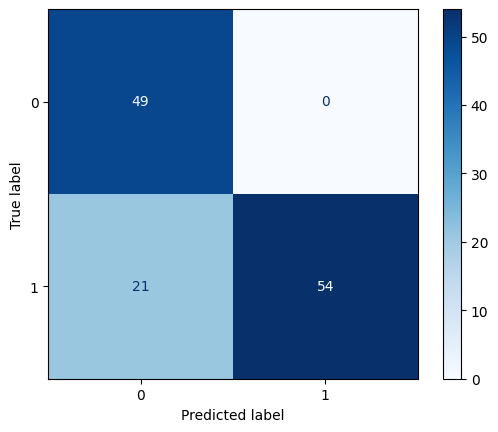

<ipython-input-42-40c4bd8a10bc>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_messages), 'text':new_messages}), ignore_index = True)


Spam percentage = 0.4903786468032278
Epoch 1/10
320/322 [============================>.] - ETA: 0s - loss: 0.0701 - accuracy: 0.9771

322/322 [==============================] - 20s 41ms/step - loss: 0.0697 - accuracy: 0.9773 - val_loss: 0.7870 - val_accuracy: 0.8306
Epoch 2/10
322/322 [==============================] - 5s 14ms/step - loss: 0.0011 - accuracy: 0.9994
Epoch 3/10
322/322 [==============================] - 3s 10ms/step - loss: 3.6247e-05 - accuracy: 1.0000
Epoch 4/10
322/322 [==============================] - 4s 12ms/step - loss: 1.8485e-05 - accuracy: 1.0000
Epoch 5/10
322/322 [==============================] - 3s 10ms/step - loss: 1.1002e-05 - accuracy: 1.0000
Epoch 6/10
  7/322 [..............................] - ETA: 2s - loss: 8.6052e-06 - accuracy: 1.0000

4/4 [==============================] - 1s 5ms/step
test accuracy = 0.8225806451612904
Recall = 0.7066666666666667
Precision = 1.0
F1 score = 0.828125
F2 score = 0.7507082152974504
MCC = 0.6983548743414282
              precision    recall  f1-score   support

           0       0.69      1.00      0.82        49
           1       1.00      0.71      0.83        75

    accuracy                           0.82       124
   macro avg       0.85      0.85      0.82       124
weighted avg       0.88      0.82      0.82       124



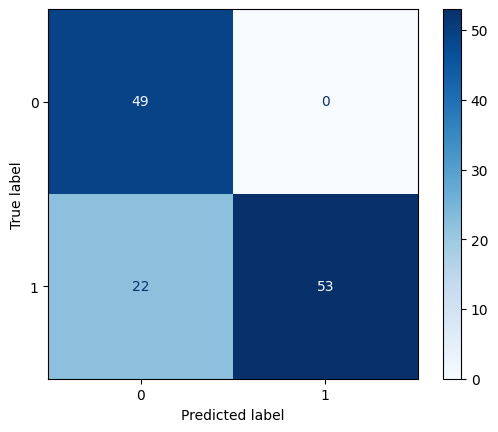

<ipython-input-42-40c4bd8a10bc>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_messages), 'text':new_messages}), ignore_index = True)


Spam percentage = 0.39364844903988183
Epoch 1/10
269/270 [============================>.] - ETA: 0s - loss: 0.0949 - accuracy: 0.9635

270/270 [==============================] - 20s 47ms/step - loss: 0.0946 - accuracy: 0.9636 - val_loss: 0.6293 - val_accuracy: 0.8710
Epoch 2/10
270/270 [==============================] - 3s 11ms/step - loss: 0.0029 - accuracy: 0.9996
Epoch 3/10
270/270 [==============================] - 3s 12ms/step - loss: 5.9178e-05 - accuracy: 1.0000
Epoch 4/10
270/270 [==============================] - 3s 13ms/step - loss: 3.0653e-05 - accuracy: 1.0000
Epoch 5/10
270/270 [==============================] - 3s 10ms/step - loss: 1.8953e-05 - accuracy: 1.0000
Epoch 6/10
 10/270 [>.............................] - ETA: 6s - loss: 1.4282e-05 - accuracy: 1.0000

4/4 [==============================] - 1s 5ms/step
test accuracy = 0.8709677419354839
Recall = 0.7866666666666666
Precision = 1.0
F1 score = 0.8805970149253731
F2 score = 0.8217270194986072
MCC = 0.7700815807598835
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        49
           1       1.00      0.79      0.88        75

    accuracy                           0.87       124
   macro avg       0.88      0.89      0.87       124
weighted avg       0.90      0.87      0.87       124



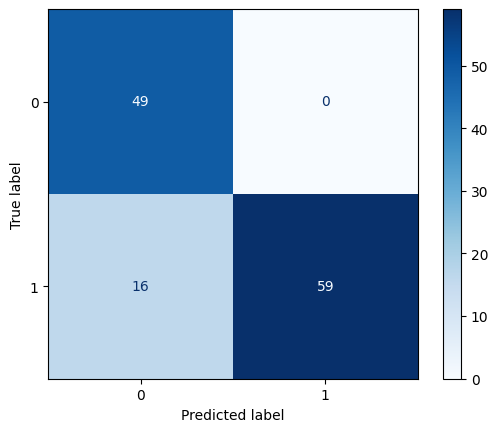

<ipython-input-42-40c4bd8a10bc>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_messages), 'text':new_messages}), ignore_index = True)


Spam percentage = 0.32092638544251445
Epoch 1/10
237/241 [============================>.] - ETA: 0s - loss: 0.0969 - accuracy: 0.9629

241/241 [==============================] - 19s 53ms/step - loss: 0.0953 - accuracy: 0.9635 - val_loss: 0.6326 - val_accuracy: 0.8548
Epoch 2/10
241/241 [==============================] - 3s 10ms/step - loss: 3.3338e-04 - accuracy: 1.0000
Epoch 3/10
241/241 [==============================] - 3s 13ms/step - loss: 6.2893e-05 - accuracy: 1.0000
Epoch 4/10
241/241 [==============================] - 2s 10ms/step - loss: 3.2023e-05 - accuracy: 1.0000
Epoch 5/10
241/241 [==============================] - 2s 9ms/step - loss: 1.9062e-05 - accuracy: 1.0000
Epoch 6/10
  1/241 [..............................] - ETA: 2s - loss: 8.3126e-06 - accuracy: 1.0000

4/4 [==============================] - 2s 6ms/step
test accuracy = 0.8387096774193549
Recall = 0.7333333333333333
Precision = 1.0
F1 score = 0.846153846153846
F2 score = 0.7746478873239436
MCC = 0.7216459982982677
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        49
           1       1.00      0.73      0.85        75

    accuracy                           0.84       124
   macro avg       0.86      0.87      0.84       124
weighted avg       0.89      0.84      0.84       124



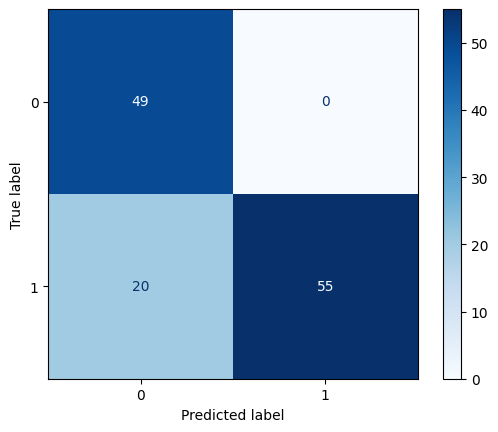

<ipython-input-42-40c4bd8a10bc>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_messages), 'text':new_messages}), ignore_index = True)


Spam percentage = 0.22620169651272384
Epoch 1/10
210/212 [============================>.] - ETA: 0s - loss: 0.1190 - accuracy: 0.9570

212/212 [==============================] - 18s 52ms/step - loss: 0.1179 - accuracy: 0.9574 - val_loss: 0.5943 - val_accuracy: 0.8548
Epoch 2/10
212/212 [==============================] - 3s 15ms/step - loss: 0.0021 - accuracy: 0.9995
Epoch 3/10
212/212 [==============================] - 3s 13ms/step - loss: 7.8225e-05 - accuracy: 1.0000
Epoch 4/10
212/212 [==============================] - 3s 12ms/step - loss: 4.0873e-05 - accuracy: 1.0000
Epoch 5/10
212/212 [==============================] - 2s 10ms/step - loss: 2.5492e-05 - accuracy: 1.0000
Epoch 6/10
 10/212 [>.............................] - ETA: 4s - loss: 1.8693e-05 - accuracy: 1.0000

4/4 [==============================] - 1s 5ms/step
test accuracy = 0.8548387096774194
Recall = 0.76
Precision = 1.0
F1 score = 0.8636363636363636
F2 score = 0.7983193277310925
MCC = 0.74553396671271
              precision    recall  f1-score   support

           0       0.73      1.00      0.84        49
           1       1.00      0.76      0.86        75

    accuracy                           0.85       124
   macro avg       0.87      0.88      0.85       124
weighted avg       0.89      0.85      0.86       124



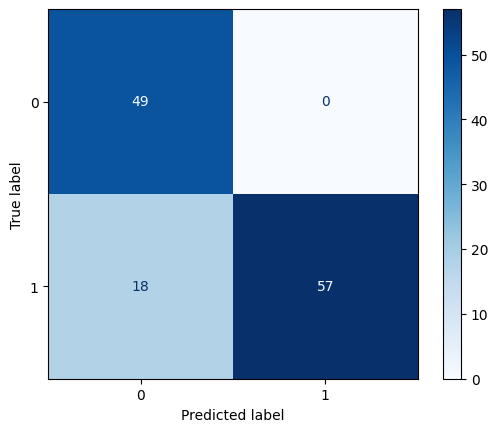

<ipython-input-42-40c4bd8a10bc>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_messages), 'text':new_messages}), ignore_index = True)


Spam percentage = 0.18551587301587302
Epoch 1/10
201/201 [==============================] - ETA: 0s - loss: 0.1253 - accuracy: 0.9527

201/201 [==============================] - 18s 58ms/step - loss: 0.1253 - accuracy: 0.9527 - val_loss: 0.6208 - val_accuracy: 0.8548
Epoch 2/10
201/201 [==============================] - 3s 16ms/step - loss: 0.0023 - accuracy: 0.9995
Epoch 3/10
201/201 [==============================] - 2s 12ms/step - loss: 1.4272e-04 - accuracy: 1.0000
Epoch 4/10
201/201 [==============================] - 2s 11ms/step - loss: 7.0550e-05 - accuracy: 1.0000
Epoch 5/10
201/201 [==============================] - 2s 10ms/step - loss: 4.3230e-05 - accuracy: 1.0000
Epoch 6/10
  1/201 [..............................] - ETA: 2s - loss: 3.1774e-05 - accuracy: 1.0000

4/4 [==============================] - 1s 5ms/step
test accuracy = 0.8629032258064516
Recall = 0.7866666666666666
Precision = 0.9833333333333333
F1 score = 0.8740740740740739
F2 score = 0.8194444444444443
MCC = 0.7496151695999295
              precision    recall  f1-score   support

           0       0.75      0.98      0.85        49
           1       0.98      0.79      0.87        75

    accuracy                           0.86       124
   macro avg       0.87      0.88      0.86       124
weighted avg       0.89      0.86      0.86       124



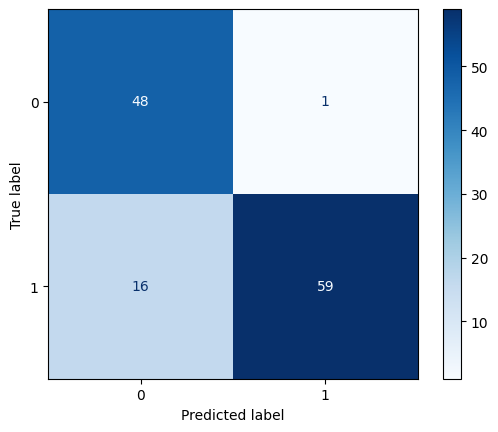

<ipython-input-42-40c4bd8a10bc>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_messages), 'text':new_messages}), ignore_index = True)


Spam percentage = 0.16734279918864098
Epoch 1/10
197/197 [==============================] - ETA: 0s - loss: 0.1133 - accuracy: 0.9598

197/197 [==============================] - 17s 54ms/step - loss: 0.1133 - accuracy: 0.9598 - val_loss: 0.5373 - val_accuracy: 0.8871
Epoch 2/10
197/197 [==============================] - 3s 16ms/step - loss: 0.0025 - accuracy: 0.9990
Epoch 3/10
197/197 [==============================] - 3s 13ms/step - loss: 1.1057e-04 - accuracy: 1.0000
Epoch 4/10
197/197 [==============================] - 2s 10ms/step - loss: 4.8803e-05 - accuracy: 1.0000
Epoch 5/10
197/197 [==============================] - 2s 12ms/step - loss: 3.0266e-05 - accuracy: 1.0000
Epoch 6/10
  5/197 [..............................] - ETA: 8s - loss: 2.4648e-05 - accuracy: 1.0000

4/4 [==============================] - 1s 5ms/step
test accuracy = 0.8870967741935484
Recall = 0.8133333333333334
Precision = 1.0
F1 score = 0.8970588235294117
F2 score = 0.8448753462603877
MCC = 0.7953568963632569
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        49
           1       1.00      0.81      0.90        75

    accuracy                           0.89       124
   macro avg       0.89      0.91      0.89       124
weighted avg       0.91      0.89      0.89       124



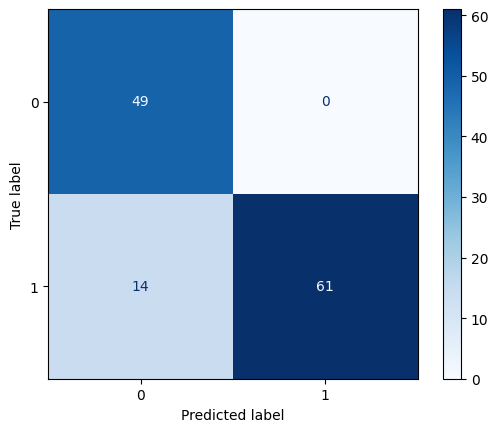

<ipython-input-42-40c4bd8a10bc>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_messages), 'text':new_messages}), ignore_index = True)


Spam percentage = 0.1474558670820353
Epoch 1/10
190/192 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9556

192/192 [==============================] - 18s 55ms/step - loss: 0.1241 - accuracy: 0.9561 - val_loss: 0.5613 - val_accuracy: 0.8548
Epoch 2/10
192/192 [==============================] - 3s 17ms/step - loss: 8.1718e-04 - accuracy: 1.0000
Epoch 3/10
192/192 [==============================] - 2s 12ms/step - loss: 1.0208e-04 - accuracy: 1.0000
Epoch 4/10
192/192 [==============================] - 3s 15ms/step - loss: 5.4042e-05 - accuracy: 1.0000
Epoch 5/10
192/192 [==============================] - 2s 10ms/step - loss: 3.4155e-05 - accuracy: 1.0000
Epoch 6/10
 10/192 [>.............................] - ETA: 4s - loss: 2.0481e-05 - accuracy: 1.0000

4/4 [==============================] - 1s 5ms/step
test accuracy = 0.8548387096774194
Recall = 0.76
Precision = 1.0
F1 score = 0.8636363636363636
F2 score = 0.7983193277310925
MCC = 0.74553396671271
              precision    recall  f1-score   support

           0       0.73      1.00      0.84        49
           1       1.00      0.76      0.86        75

    accuracy                           0.85       124
   macro avg       0.87      0.88      0.85       124
weighted avg       0.89      0.85      0.86       124



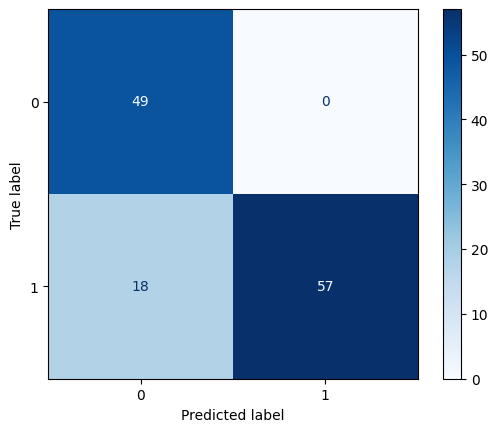

In [ ]:
word_sim_range = [.625, .65, .675, .7, .725, .75, .775, .8]

similarity_percentage_f1score = {}
similarity_percentage_f2score = {}

for value in word_sim_range:
  all_similar_words = {}
  my_augmented_dataset =  my_augmentation(train_data, 1, value)
  my_aug_X = my_augmented_dataset['text'].to_numpy()
  my_aug_y = my_augmented_dataset['label'].to_numpy()
  print('Spam percentage = {}'.format(np.count_nonzero(my_aug_y) / len(my_aug_y)))
  similarity_percentage_f1score[value], similarity_percentage_f2score[value] = train_blstm(total_length, text_words_mean, my_aug_X, my_aug_y)

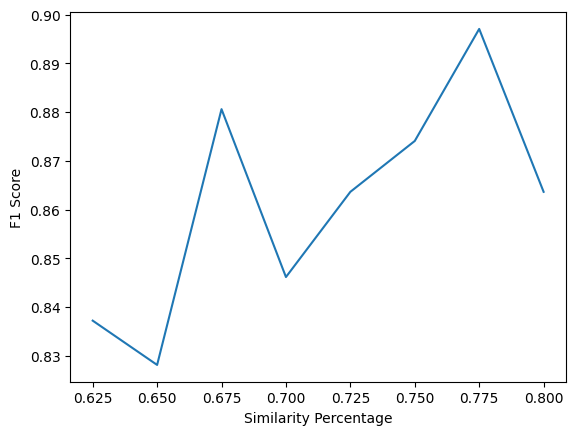

In [ ]:
x_values, y_values = zip(*similarity_percentage_f1score.items())
plt.plot(x_values, y_values)
plt.xlabel('Similarity Percentage')
plt.ylabel('F1 Score')
plt.show()

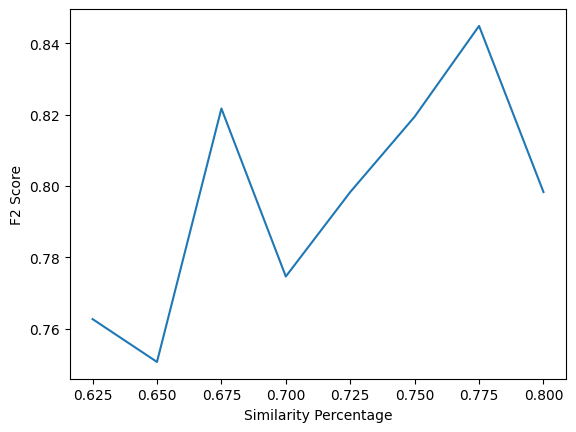

In [ ]:
x_values, y_values = zip(*similarity_percentage_f2score.items())
plt.plot(x_values, y_values)
plt.xlabel('Similarity Percentage')
plt.ylabel('F2 Score')
plt.show()

<ipython-input-42-40c4bd8a10bc>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_messages), 'text':new_messages}), ignore_index = True)


Epoch 1/10
195/197 [============================>.] - ETA: 0s - loss: 0.1242 - accuracy: 0.9553

197/197 [==============================] - 21s 63ms/step - loss: 0.1231 - accuracy: 0.9557 - val_loss: 0.3509 - val_accuracy: 0.9032
Epoch 2/10
197/197 [==============================] - 4s 21ms/step - loss: 2.8462e-04 - accuracy: 1.0000
Epoch 3/10
197/197 [==============================] - 3s 15ms/step - loss: 6.5368e-05 - accuracy: 1.0000
Epoch 4/10
197/197 [==============================] - 2s 13ms/step - loss: 3.2524e-05 - accuracy: 1.0000
Epoch 5/10
197/197 [==============================] - 3s 14ms/step - loss: 1.8957e-05 - accuracy: 1.0000
Epoch 6/10
  1/197 [..............................] - ETA: 2s - loss: 1.9486e-05 - accuracy: 1.0000

4/4 [==============================] - 1s 6ms/step
test accuracy = 0.8951612903225806
Recall = 0.84
Precision = 0.984375
F1 score = 0.9064748201438849
F2 score = 0.8653846153846153
MCC = 0.8017900890749247
              precision    recall  f1-score   support

           0       0.80      0.98      0.88        49
           1       0.98      0.84      0.91        75

    accuracy                           0.90       124
   macro avg       0.89      0.91      0.89       124
weighted avg       0.91      0.90      0.90       124



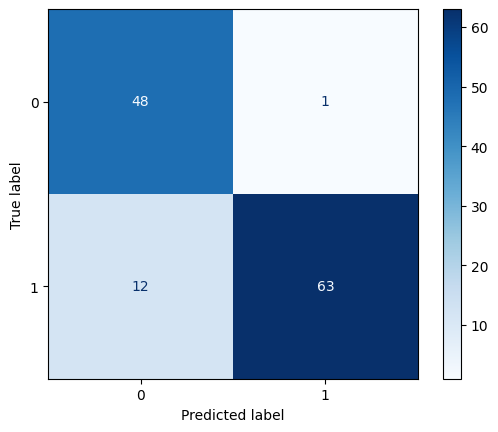

(0.9064748201438849, 0.8653846153846153)

In [ ]:
all_similar_words = {}
my_augmented_dataset =  my_augmentation(train_data, 1, .775)

my_aug_X = my_augmented_dataset['text'].to_numpy()
my_aug_y = my_augmented_dataset['label'].to_numpy()

train_blstm(total_length, text_words_mean, my_aug_X, my_aug_y)